# Visualizing Text Embeddings Using Hugging Face Models

This tutorial explores how to visualize the latent spaces of text embeddings (word and sentence level) using models from the Hugging Face Transformers library. We'll cover what latent spaces are, why they're important, and how to extract and visualize them from pre-trained models.

## 1. Introduction to Latent Spaces

A **latent space** (also known as a latent representation or embedding space) is a compressed representation of data where similar items are positioned closer together. These spaces are "latent" because they represent hidden factors that explain the observed data.

### Why are latent spaces important?

- They enable dimensionality reduction, converting high-dimensional data into more manageable lower-dimensional representations
- They capture semantic relationships between data points
- They allow for meaningful data manipulations (interpolation, arithmetic operations)
- They provide insights into how models internally represent information

In NLP, visualizing latent spaces can help us understand:
- How models cluster similar concepts
- Which features the model considers important
- Potential biases in the model's representations
- How different architectures learn different representations

## 2. Setting Up the Environment

Let's install the necessary libraries for our tutorial:

In [ ]:
# Install required packages
# if you use conda (uncomment):
#%conda install transformers torch scikit-learn matplotlib pandas seaborn umap-learn sentence-transformers
# if not use pip (uncomment): 
# %pip install transformers torch scikit-learn matplotlib pandas seaborn umap-learn sentence-transformers
# 
# you may want to create an environment for that with
# conda create -n myenv
# conda activate myenv
# conda install [write all the modules needed above]
# run your notebook from this environment


In [ ]:
# Import libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP
from sentence_transformers import SentenceTransformer

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 3. Example 1: Visualizing Word Embeddings

Let's start with a simple example: visualizing word embeddings from a language model. We'll use BERT's embeddings for a set of words and visualize how they relate to each other in the latent space.

In [ ]:
# Load a pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
# Define some words to visualize
words = [
    # Animals
    "dog", "cat", "horse", "cow", "lion", "tiger", "elephant", "giraffe",
    # Fruits
    "apple", "banana", "orange", "grape", "pear", "strawberry", "blueberry", "watermelon",
    # Countries
    "usa", "canada", "mexico", "france", "germany", "china", "japan", "australia",
    # Technology
    "computer", "phone", "internet", "software", "hardware", "algorithm", "data", "cloud"
]

# Create labels for our categories
categories = ["Animal"]*8 + ["Fruit"]*8 + ["Country"]*8 + ["Technology"]*8

In [ ]:
# Function to get embeddings for a list of words
def get_word_embeddings(words, model, tokenizer):
    # Initialize an empty list to store embeddings
    embeddings = []
    
    # Set the model to evaluation mode
    model.eval()
    
    # Process each word
    with torch.no_grad():  # No need to calculate gradients
        for word in words:
            # Tokenize the word and convert to tensor
            inputs = tokenizer(word, return_tensors="pt", padding=True, truncation=True)
            
            # Forward pass through the model
            outputs = model(**inputs)
            
            # Get the embedding (we'll use the [CLS] token embedding as the word representation)
            embedding = outputs.last_hidden_state[:, 0, :].numpy()
            embeddings.append(embedding[0])
    
    # Convert list to numpy array
    return np.array(embeddings)

# Get embeddings for our words
word_embeddings = get_word_embeddings(words, model, tokenizer)

### Dimensionality Reduction

Now that we have our word embeddings (which are 768-dimensional vectors from BERT), we need to reduce them to 2D for visualization. We'll try three common methods: PCA, t-SNE, and UMAP.

In [ ]:
# Reduce dimensions with PCA
pca = PCA(n_components=2, random_state=42)
word_embeddings_pca = pca.fit_transform(word_embeddings)

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
word_embeddings_tsne = tsne.fit_transform(word_embeddings)

# Reduce dimensions with UMAP
umap = UMAP(n_components=2, n_neighbors=5, min_dist=0.3, random_state=42)
word_embeddings_umap = umap.fit_transform(word_embeddings)

### Visualization Functions

Let's create a function to visualize our reduced embeddings:

In [ ]:
def plot_embeddings(embeddings, labels, words, title):
    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'x': embeddings[:, 0],
        'y': embeddings[:, 1],
        'label': labels,
        'word': words
    })
    
    # Create a color map for our categories
    category_colors = {"Animal": "#1f77b4", "Fruit": "#ff7f0e", 
                       "Country": "#2ca02c", "Technology": "#d62728"}
    
    # Create the plot
    plt.figure(figsize=(12, 10))
    
    # Create a scatter plot
    for category, color in category_colors.items():
        category_data = df[df['label'] == category]
        plt.scatter(category_data['x'], category_data['y'], c=color, label=category, alpha=0.7, s=100)
    
    # Add labels for each point
    for i, row in df.iterrows():
        plt.annotate(row['word'], (row['x'], row['y']), fontsize=9, 
                     xytext=(5, 5), textcoords='offset points')
    
    # Add title and legend
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize PCA results
plot_embeddings(word_embeddings_pca, categories, words, "Word Embeddings Visualization using PCA")

In [ ]:
# Visualize t-SNE results
plot_embeddings(word_embeddings_tsne, categories, words, "Word Embeddings Visualization using t-SNE")

In [ ]:
# Visualize UMAP results
plot_embeddings(word_embeddings_umap, categories, words, "Word Embeddings Visualization using UMAP")

## 4. Example 2: Sentence Embeddings Visualization

Now let's visualize sentence embeddings using a sentence transformer model. This will help us understand how sentences with similar meanings are represented in the latent space.

In [ ]:
# Load a pre-trained sentence transformer
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# Define some sentences to visualize
sentences = [
    # Technology
    "Artificial intelligence is transforming industries worldwide.",
    "Machine learning algorithms can identify patterns in large datasets.",
    "Neural networks have revolutionized computer vision tasks.",
    "Big data analytics provides valuable insights for businesses.",
    "Cloud computing offers scalable solutions for modern applications.",
    
    # Nature
    "The rainforest is home to countless species of plants and animals.",
    "Ocean conservation efforts are crucial for marine biodiversity.",
    "National parks protect natural habitats from human development.",
    "Climate change threatens ecosystems around the world.",
    "Sustainable practices can help preserve our natural resources.",
    
    # Food
    "Traditional cuisine reflects cultural heritage and local ingredients.",
    "Vegetarian diets can provide all necessary nutrients when properly planned.",
    "Food preservation techniques have evolved throughout human history.",
    "Culinary arts combine science and creativity in the kitchen.",
    "Seasonal cooking emphasizes fresh, locally-sourced ingredients.",
    
    # Sports
    "Team sports promote cooperation and communication skills.",
    "Olympic athletes train for years to compete at the highest level.",
    "Regular exercise contributes to overall physical and mental health.",
    "Sports psychology helps athletes optimize their performance.",
    "International competitions bring together people from diverse backgrounds."
]

# Create labels for our categories
sentence_categories = ["Technology"]*5 + ["Nature"]*5 + ["Food"]*5 + ["Sports"]*5

In [ ]:
# Generate embeddings for the sentences
sentence_embeddings = sentence_model.encode(sentences)

In [ ]:
# Apply dimensionality reduction
# PCA
pca = PCA(n_components=2, random_state=42)
sentence_embeddings_pca = pca.fit_transform(sentence_embeddings)

# t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
sentence_embeddings_tsne = tsne.fit_transform(sentence_embeddings)

# UMAP
umap = UMAP(n_components=2, n_neighbors=5, min_dist=0.3, random_state=42)
sentence_embeddings_umap = umap.fit_transform(sentence_embeddings)

In [ ]:
# Create a new plotting function for sentences
def plot_sentence_embeddings(embeddings, labels, sentences, title):
    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'x': embeddings[:, 0],
        'y': embeddings[:, 1],
        'label': labels,
        'sentence': sentences
    })
    
    # Create a color map for our categories
    category_colors = {"Technology": "#1f77b4", "Nature": "#ff7f0e", 
                       "Food": "#2ca02c", "Sports": "#d62728"}
    
    # Create the plot
    plt.figure(figsize=(15, 12))
    
    # Create a scatter plot
    for category, color in category_colors.items():
        category_data = df[df['label'] == category]
        plt.scatter(category_data['x'], category_data['y'], c=color, label=category, alpha=0.7, s=100)
    
    # Add a numeric label for each point
    for i, row in df.iterrows():
        plt.annotate(str(i+1), (row['x'], row['y']), fontsize=12, fontweight='bold',
                     xytext=(5, 5), textcoords='offset points')
    
    # Add title and legend
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    # Add a table with the sentences below the plot
    sentence_table = "\nSentence Key:\n"
    for i, sentence in enumerate(sentences):
        sentence_table += f"{i+1}. {sentence}\n"
    
    plt.figtext(0.5, -0.1, sentence_table, wrap=True, fontsize=10, ha='center')
    plt.subplots_adjust(bottom=0.4)
    
    plt.show()

In [ ]:
# Visualize the sentence embeddings
plot_sentence_embeddings(sentence_embeddings_tsne, sentence_categories, sentences, 
                         "Sentence Embeddings Visualization using t-SNE")

## 5. Advanced Analysis: Latent Space Arithmetic

One fascinating property of latent spaces is that they often support meaningful vector arithmetic. For example, the classic word embedding example: king - man + woman = queen. Let's explore some of these operations with our models.

In [ ]:
# Using the BERT word embeddings from earlier
def perform_word_vector_arithmetic(word1, word2, word3, model, tokenizer, n_results=5):
    """
    Performs word vector arithmetic: word1 - word2 + word3
    E.g., king - man + woman = queen
    """
    # Get embeddings for our words
    words = [word1, word2, word3]
    embeddings = get_word_embeddings(words, model, tokenizer)
    
    # Perform the arithmetic
    result_embedding = embeddings[0] - embeddings[1] + embeddings[2]
    
    # Now, we'd typically find the closest word in the vocabulary to this result
    # However, for demonstration, we'll just print the resulting vector
    print(f"Performed: {word1} - {word2} + {word3}")
    print(f"Result embedding shape: {result_embedding.shape}")
    
    # In a full implementation, we would load the entire vocabulary embeddings
    # and find the closest vectors using cosine similarity
    return result_embedding

# Example: king - man + woman = ?
result_embedding = perform_word_vector_arithmetic("king", "man", "woman", model, tokenizer)

# Note: To find the actual closest word, we would need to compute embeddings for the entire vocabulary
# and find the closest using cosine similarity, which is computationally expensive

In [ ]:
words = ["king", "man", "woman", "queen"]
embeddings = get_word_embeddings(words, model, tokenizer)
result_embedding2 = result_embedding[np.newaxis,:]
print("Distances between embeddings:")
print("L2 norm:")
for (i,word) in enumerate(words):
    print(f"{word} and result:", np.linalg.norm(embeddings[i, np.newaxis]-result_embedding2,2))

print("L1 norm:")
for (i,word) in enumerate(words):
    print(f"{word} and result:", np.linalg.norm(embeddings[i, np.newaxis]-result_embedding2,1))

print("Cosine similarity:")
for (i,word) in enumerate(words):
    print(f"{word} and result:", cosine_similarity(embeddings[i, np.newaxis],result_embedding2)[0][0])


## 6. Exploring the Latent Space: Interpolation

Another interesting property of latent spaces is that we can interpolate between points to see how the representation changes smoothly. Let's implement this for our sentence embeddings.

In [ ]:
def interpolate_sentences(sentence1, sentence2, model, steps=10):
    """
    Interpolate between two sentence embeddings and decode at each step.
    This allows us to explore the latent space between sentences.
    """
    # Encode the sentences
    embedding1 = model.encode([sentence1])[0]
    embedding2 = model.encode([sentence2])[0]
    
    # Create interpolation steps
    alphas = np.linspace(0, 1, steps)
    interpolated_embeddings = []
    
    # Generate interpolated embeddings
    for alpha in alphas:
        interpolated = (1 - alpha) * embedding1 + alpha * embedding2
        interpolated_embeddings.append(interpolated)
    
    # Convert to numpy array
    interpolated_embeddings = np.array(interpolated_embeddings)
    
    # Print interpolation details
    print(f"Interpolating between:\n1. '{sentence1}'\n2. '{sentence2}'")
    print(f"Generated {steps} interpolated embeddings")
    
    return interpolated_embeddings, alphas

# Example sentences
sentence1 = "Artificial intelligence is transforming our world."
sentence2 = "Natural ecosystems are vital for environmental balance."

# Generate interpolated embeddings
interpolated_embeddings, alphas = interpolate_sentences(sentence1, sentence2, sentence_model)

In [ ]:
# Visualize the interpolation trajectory
# Reduce the dimensionality of the interpolated embeddings
# First, we'll reduce the dimensionality of our original sentence embeddings and interpolated embeddings together

# Combine the original sentence embeddings with the interpolated ones for consistent dimensionality reduction
combined_embeddings = np.vstack([sentence_embeddings, interpolated_embeddings])
pca = PCA(n_components=2, random_state=42)
combined_reduced = pca.fit_transform(combined_embeddings)

# Split back to original and interpolated
original_reduced = combined_reduced[:len(sentence_embeddings)]
interpolated_reduced = combined_reduced[len(sentence_embeddings):]

# Visualize
plt.figure(figsize=(12, 10))

# Plot original sentence embeddings as background
plt.scatter(original_reduced[:, 0], original_reduced[:, 1], c="lightgray", alpha=0.5, s=50)

# Plot interpolation trajectory with color gradient
for i in range(len(interpolated_reduced) - 1):
    plt.plot(interpolated_reduced[i:i+2, 0], interpolated_reduced[i:i+2, 1], 
             'o-', c=plt.cm.viridis(alphas[i]), linewidth=2, markersize=10)

# Mark start and end points
plt.scatter(interpolated_reduced[0, 0], interpolated_reduced[0, 1], c="blue", s=200, marker="*", label="Start")
plt.scatter(interpolated_reduced[-1, 0], interpolated_reduced[-1, 1], c="red", s=200, marker="*", label="End")

plt.title("Latent Space Interpolation Trajectory", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 7. Dimensionality Reduction Techniques Compared

Let's discuss the different dimensionality reduction techniques we've used:

### 7.1 Principal Component Analysis (PCA)

**Advantages:**
- Linear and deterministic (same results on multiple runs)
- Preserves global structure and directions of maximum variance
- Computationally efficient, even for larger datasets
- Can explain how much variance each dimension captures

**Disadvantages:**
- Cannot capture non-linear relationships in the data
- May not preserve local structure well
- Performance degrades in very high dimensions with non-linear manifolds

**Best used when:**
- You want to understand global variance directions
- Data has approximately linear relationships
- You need deterministic, reproducible results
- You're working with very large datasets where computational efficiency matters

### 7.2 t-Distributed Stochastic Neighbor Embedding (t-SNE)

**Advantages:**
- Excellent at preserving local structure and finding clusters
- Can reveal patterns hidden in high-dimensional space
- Handles non-linear relationships well
- Works well for visualizing natural clusters in data

**Disadvantages:**
- Stochastic (different results on multiple runs)
- Does not preserve global structure well
- Can be computationally expensive
- Sensitive to hyperparameters (especially perplexity)
- Not good for downstream tasks beyond visualization

**Best used when:**
- You want to visualize clusters and local neighborhoods
- Global distances between separated clusters are less important
- You want to explore the data without strict reproducibility requirements

How to use t-SNE : https://distill.pub/2016/misread-tsne/ 

### 7.3 Uniform Manifold Approximation and Projection (UMAP)

**Advantages:**
- Preserves both local and global structure better than t-SNE
- Faster than t-SNE, especially for larger datasets
- More stable across multiple runs than t-SNE
- Can be used for dimensionality reduction as a preprocessing step, not just visualization
- Supports supervised dimension reduction

**Disadvantages:**
- Still somewhat stochastic (though more stable than t-SNE)
- Has multiple hyperparameters that need tuning
- Theoretical foundations more complex than PCA or t-SNE

**Best used when:**
- You want a balance between preserving local and global structure
- You need faster performance than t-SNE for larger datasets
- You plan to use the reduced dimensions for downstream tasks

Resources: https://pair-code.github.io/understanding-umap/

An example from this link:
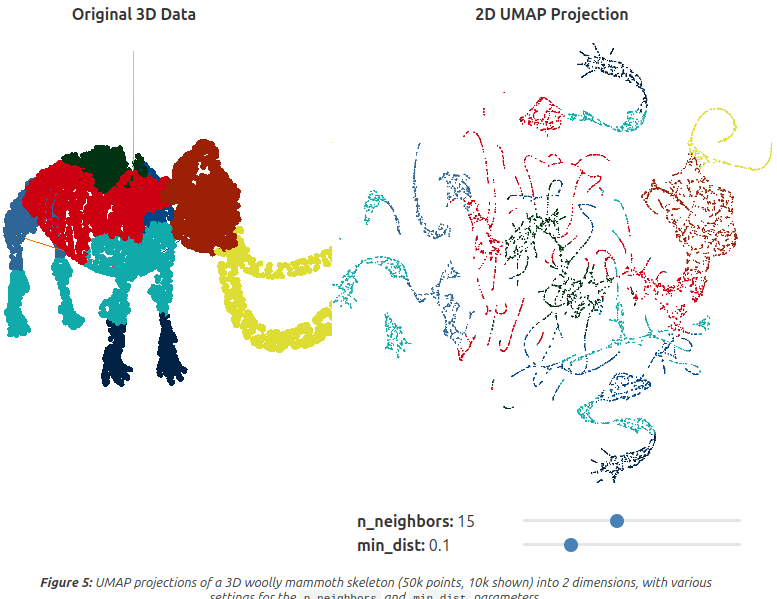

The 3D mammuth is projected into 2D, the shapes are not preserved but the points close in 3D stay close in the 2D representation (points with same color are next to each other). That is a good illusration of the effect of UMAP and t-SNE.


## 8. Conclusion and Best Practices

### Key takeaways for visualizing text embeddings in latent space:

1. **Understand your goal:**
   - For cluster analysis and pattern discovery, t-SNE or UMAP often work best
   - For understanding variance directions, PCA is more appropriate
   - For balancing local and global structure, UMAP is a good choice

2. **Be aware of limitations:**
   - Dimensionality reduction always loses information
   - Different algorithms preserve different aspects of the data
   - Random initializations can affect results (especially for t-SNE)

3. **Tips for better visualizations:**
   - Try multiple dimensionality reduction techniques and compare results
   - Experiment with hyperparameters (perplexity for t-SNE, n_neighbors for UMAP)
   - Use appropriate color coding and labels
   - For large datasets, consider subsampling or using incremental techniques

4. **Interpreting text embedding visualizations:**
   - Proximity in the visualization generally means semantic similarity
   - Clusters often represent related concepts or topics
   - Directions in the latent space may correspond to linguistic attributes
   - Outliers could be interesting cases or potential errors

5. **Beyond visualization:**
   - Text embeddings can be used for search, recommendation, and document classification
   - Vector arithmetic in latent space can reveal interesting semantic relationships
   - Interpolation between points can help understand gradual semantic shifts
   - Clustering in latent space can identify natural language groupings

Resources: 
- Nice demo of different visualizations for MNIST: https://colah.github.io/posts/2014-10-Visualizing-MNIST/ 
- Interactive demo: https://projector.tensorflow.org/ 



## 9. Additional Exploration Ideas

Here are some additional ideas to explore text embeddings further:

1. **Compare different models:** Try different language models (BERT vs. RoBERTa vs. GPT) and see how their latent spaces differ

2. **Layer-wise analysis:** Extract embeddings from different layers of a model to see how representations evolve

3. **Fine-tuning effects:** Compare latent spaces before and after fine-tuning on a specific task

4. **Domain-specific embeddings:** Explore how models trained on specific domains (e.g., biomedical texts, legal documents) organize their latent spaces

5. **Multilingual embeddings:** Compare how concepts are arranged in the latent space across different languages

6. **Interactive visualization:** Use tools like Tensorboard Projector for interactive embedding exploration

7. **Temporal analysis:** For sequence models, visualize how embeddings evolve across time steps in a sentence

8. **Attention visualization:** Combine latent space visualization with attention weights for deeper insights